In [1]:
import warnings
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotnine as gg
import umap
from numba.core.errors import NumbaWarning

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from dask_searchcv import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix
)

from utils.data_utils import load_data
from utils.ml_utils import get_threshold_metrics, shuffle_columns

from pycytominer.cyto_utils import infer_cp_features

In [2]:
warnings.filterwarnings("ignore", category=NumbaWarning)

In [3]:
def get_threshold_metrics(y_true, y_pred, drop_intermediate=False):
    """
    Retrieve true/false positive rates and auroc/aupr for class predictions
    Arguments:
    y_true - an array of gold standard mutation status
    y_pred - an array of predicted mutation status
    disease - a string that includes the corresponding TCGA study acronym
    Output:
    dict of AUROC, AUPR, pandas dataframes of ROC and PR data, and cancer-type
    """

    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(
        roc_columns,
        roc_curve(y_true, y_pred, drop_intermediate=drop_intermediate)
     )
    roc_df = pd.DataFrame.from_dict(dict(roc_items))

    pr_columns = ['precision', 'recall', 'threshold']
    prec, rec, thresh = precision_recall_curve(y_true, y_pred)
    pr_df = pd.DataFrame.from_records([prec, rec]).transpose()
    pr_df = pd.concat([pr_df, pd.Series(thresh)], ignore_index=True, axis=1)
    pr_df.columns = pr_columns

    auroc = roc_auc_score(y_true, y_pred, average='weighted')
    avg_precision = average_precision_score(y_true, y_pred, average='weighted')
    
    metric_dict = {
        'auroc': auroc,
        'average_precision': avg_precision,
        'roc_df': roc_df,
        'pr_df': pr_df,
    }
    return metric_dict

## Set Parameters

In [4]:
alphas = [0.001, 0.2, 0.3, 0.4, 0.5, 0.6, 1]
l1_ratios = [0.1, 0.2, 0.3, 0.4, 1]
n_folds = 5
np.random.seed(12345)

## Load Data

In [5]:
x_train_df, y_train_df, meta_train_df, x_test_df, y_test_df, meta_test_df = load_data(
    y_col="Metadata_CellLine", wt_col="WT", return_meta=True, shuffle_row_order=True
)
print(x_train_df.shape)
print(x_test_df.shape)

x_test_df.head(3)

(30037, 898)
(5301, 898)


,Cells_AreaShape_Area,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MaxFeretDiameter,Cells_AreaShape_MeanRadius,Cells_AreaShape_MinFeretDiameter,Cells_AreaShape_MinorAxisLength,Cells_AreaShape_Orientation,...,Nuclei_Texture_SumEntropy_Mito_5_00,Nuclei_Texture_SumEntropy_Mito_5_01,Nuclei_Texture_SumEntropy_Mito_5_02,Nuclei_Texture_SumEntropy_Mito_5_03,Nuclei_Texture_SumEntropy_RNA_10_01,Nuclei_Texture_SumEntropy_RNA_10_03,Nuclei_Texture_SumEntropy_RNA_5_00,Nuclei_Texture_SumEntropy_RNA_5_01,Nuclei_Texture_SumEntropy_RNA_5_02,Nuclei_Texture_SumEntropy_RNA_5_03
0,-1.029550,0.830252,0.283315,1.259361,-0.929105,-0.926156,-1.030209,-1.329799,-1.321590,1.163391,...,0.726766,0.780172,0.772793,0.564964,1.476871,0.391862,1.270314,1.181130,1.255861,1.183522
1,0.515601,1.045608,-0.143316,-0.275257,0.849351,0.755184,0.569117,-0.017156,-0.029416,-1.109514,...,0.702128,0.852980,0.782379,0.572434,1.258878,1.147212,1.587999,1.600243,1.564991,1.662118
2,2.113801,0.095434,0.695073,-0.606875,1.336316,1.366865,2.053005,1.588999,1.815841,-1.627610,...,-0.224683,-0.243393,-0.156724,-0.141524,-0.212987,-0.714246,-0.476907,-0.380610,-0.457538,-0.442597


In [6]:
# Apply UMAP
reducer = umap.UMAP(random_state=123)
embedding = reducer.fit_transform(x_train_df)

# Setup plotting logic
embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
embedding_df = embedding_df.merge(meta_train_df, left_index=True, right_index=True)

/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 5 x 4 in image.
  from_inches(height, units), units))
/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/umap/example_cell_line_train.png
  warn('Filename: {}'.format(filename))


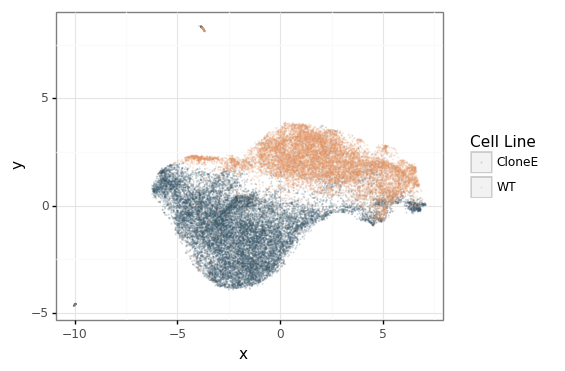

<ggplot: (-9223363279594569777)>

In [7]:
cell_line_gg = (
    gg.ggplot(embedding_df, gg.aes(x="x", y="y")) +
    gg.geom_point(gg.aes(color="Metadata_CellLine"), size = 0.1, shape = ".", alpha = 0.2) +
    gg.theme_bw() +
    gg.scale_color_manual(name="Cell Line",
                          labels={"CloneE": "CloneE", "WT": "WT"},
                          values={"CloneE": "#3B596B", "WT": "#E49665"})
)

fig_file = pathlib.Path("figures", "umap", "example_cell_line_train.png")
cell_line_gg.save(filename=fig_file, height=4, width=5, dpi=500)

cell_line_gg

/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 5 x 4 in image.
  from_inches(height, units), units))
/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/umap/example_well_train.png
  warn('Filename: {}'.format(filename))


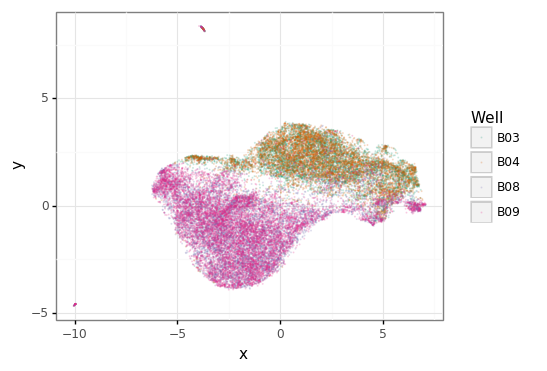

<ggplot: (-9223363279578248753)>

In [8]:
well_gg = (
    gg.ggplot(embedding_df, gg.aes(x="x", y="y")) +
    gg.geom_point(gg.aes(color="Metadata_Well"), size = 0.1, shape = ".", alpha = 0.2) +
    gg.theme_bw() +
    gg.scale_color_manual(name="Well",
                          labels={"B03": "B03", "B04": "B04", "B08": "B08", "B09": "B09"},
                          values={"B03": "#1b9e77", "B04": "#d95f02", "B08": "#7570b3", "B09": "#e7298a"})
)

fig_file = pathlib.Path("figures", "umap", "example_well_train.png")
well_gg.save(filename=fig_file, height=4, width=5, dpi=500)

well_gg

## Setup Pipeline and Fit

In [9]:
clf_parameters = {
    'classify__loss': ['log'],
    'classify__penalty': ['elasticnet'],
    'classify__alpha': alphas,
    'classify__l1_ratio': l1_ratios
}

estimator = Pipeline(
    steps=[(
        'classify',
        SGDClassifier(
            random_state=0,
            class_weight='balanced',
            loss='log',
            max_iter=50,
            tol=1e-3
        )
    )]
)

cv_pipeline = GridSearchCV(
    estimator=estimator,
    param_grid=clf_parameters,
    n_jobs=-1,
    cv=n_folds,
    scoring='average_precision',
    return_train_score=True
)
 
shuffle_cv_pipeline = GridSearchCV(
    estimator=estimator,
    param_grid=clf_parameters,
    n_jobs=-1,
    cv=n_folds,
    scoring='average_precision',
    return_train_score=True
)

In [10]:
# Fit Regular Pipeline
cv_pipeline.fit(X=x_train_df, y=y_train_df.status.tolist())

/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('classify', SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=0, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       iid=True, n_jobs=-1,
       param_grid={'classify__loss': ['log'], 'classify__penalty': ['elasticnet'], 'classify__alpha': [0.001, 0.2, 0.3, 0.4, 0.5, 0.6, 1], 'classify__l1_ratio': [0.1, 0.2, 0.3, 0.4, 1]},
       refit=True, return_train_score=True, scheduler=None,
       scoring='average_precision')

In [11]:
# Fit Shuffled Data Pipeline
x_train_shuffled_df = x_train_df.apply(shuffle_columns, axis=0, result_type="broadcast")
shuffle_cv_pipeline.fit(X=x_train_shuffled_df, y=y_train_df.status.tolist())

/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('classify', SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=0, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       iid=True, n_jobs=-1,
       param_grid={'classify__loss': ['log'], 'classify__penalty': ['elasticnet'], 'classify__alpha': [0.001, 0.2, 0.3, 0.4, 0.5, 0.6, 1], 'classify__l1_ratio': [0.1, 0.2, 0.3, 0.4, 1]},
       refit=True, return_train_score=True, scheduler=None,
       scoring='average_precision')

## Visualize Cross Validation Results

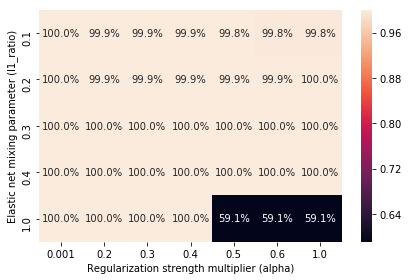

In [12]:
cv_heatmap_file = pathlib.Path("figures", "cross_validation", "cv_example_heatmap.png")

cv_results = pd.concat([pd.DataFrame(cv_pipeline.cv_results_)
                          .drop('params', axis=1),
                        pd.DataFrame.from_records(cv_pipeline
                                                  .cv_results_['params'])],
                       axis=1)

# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_results, values='mean_test_score',
                              index='classify__l1_ratio',
                              columns='classify__alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)')
plt.tight_layout()
plt.savefig(cv_heatmap_file, dpi=600, bbox_inches='tight')

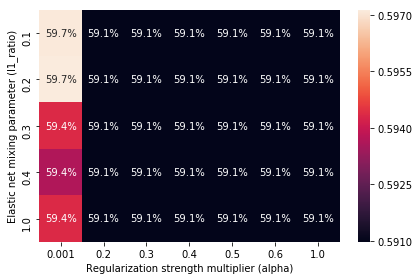

In [13]:
cv_heatmap_file = pathlib.Path("figures", "cross_validation", "cv_example_heatmap_shuffled.png")

cv_results = pd.concat([pd.DataFrame(shuffle_cv_pipeline.cv_results_)
                          .drop('params', axis=1),
                        pd.DataFrame.from_records(cv_pipeline
                                                  .cv_results_['params'])],
                       axis=1)

# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_results, values='mean_test_score',
                              index='classify__l1_ratio',
                              columns='classify__alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)')
plt.tight_layout()
plt.savefig(cv_heatmap_file, dpi=600, bbox_inches='tight')

## Generate Predictions

In [14]:
y_predict_train = cv_pipeline.decision_function(x_train_df)
y_predict_test = cv_pipeline.decision_function(x_test_df)

y_predict_shuffled_train = shuffle_cv_pipeline.decision_function(x_train_shuffled_df)
y_predict_shuffled_test = shuffle_cv_pipeline.decision_function(x_test_df)

In [15]:
y_test_meta_df = (
    y_test_df
    .assign(predicted=y_predict_test,
            predicted_shuffle=y_predict_shuffled_test)
    .merge(meta_test_df, left_index=True, right_index=True)
)
y_train_meta_df = (
    y_train_df
    .assign(predicted = y_predict_train,
            predicted_shuffle = y_predict_shuffled_train)
    .merge(meta_train_df, left_index=True, right_index=True)
)

In [16]:
y_train_meta_df.head()

,Metadata_CellLine_x,status,predicted,predicted_shuffle,Metadata_TableNumber,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_plate_map_name,Metadata_CellLine_y,Metadata_Dosage
0,CloneE,1,0.217078,-0.850881,11614671910780105997703201292894370443,7,207106_exposure320,B08,PlateMap_207106_exposure320,CloneE,0.0
1,CloneE,1,0.346909,-0.413724,152244956861347491335608050787208994501,224,207106_exposure320,B09,PlateMap_207106_exposure320,CloneE,0.0
2,WT,0,-0.154557,0.428051,67587439580612593943318871349912685108,183,207106_exposure320,B04,PlateMap_207106_exposure320,WT,0.0
3,WT,0,-0.108635,0.718871,10357269089196196728972431758490159122,74,207106_exposure320,B03,PlateMap_207106_exposure320,WT,0.0
4,WT,0,-0.151631,-0.247108,249268707860221220109617348726776219208,219,207106_exposure320,B04,PlateMap_207106_exposure320,WT,0.0


## Obtain Performance Metrics

In [17]:
y_train_metrics = get_threshold_metrics(
    y_true=y_train_meta_df.status.astype(float),
    y_pred=y_train_meta_df.predicted
)

y_test_metrics = get_threshold_metrics(
    y_true=y_test_meta_df.status.astype(float),
    y_pred=y_test_meta_df.predicted
)

y_train_shuffle_metrics = get_threshold_metrics(
    y_true=y_train_meta_df.status.astype(float),
    y_pred=y_train_meta_df.predicted_shuffle
)

y_test_shuffle_metrics = get_threshold_metrics(
    y_true=y_test_meta_df.status.astype(float),
    y_pred=y_test_meta_df.predicted_shuffle
)

## Inspect Classifier Coefficients

In [18]:
# Save classifier coefficients
final_pipeline = shuffle_cv_pipeline.best_estimator_
final_classifier = final_pipeline.named_steps['classify']

coef_df = pd.DataFrame.from_dict(
    {'feature': x_train_df.columns,
     'weight': final_classifier.coef_[0]}
)

nonzero_model_coef_df = coef_df.query("weight != 0").sort_values(by="weight").reset_index(drop=True)
print(nonzero_model_coef_df.shape)
nonzero_model_coef_df.head()

(408, 2)


,feature,weight
0,Cytoplasm_AreaShape_Zernike_9_7,-0.060891
1,Cytoplasm_Correlation_Overlap_ER_RNA,-0.060117
2,Nuclei_Texture_SumAverage_ER_5_01,-0.058548
3,Nuclei_Intensity_MedianIntensity_RNA,-0.047928
4,Cells_Correlation_K_Mito_RNA,-0.047718


In [19]:
# Save classifier coefficients
final_pipeline = cv_pipeline.best_estimator_
final_classifier = final_pipeline.named_steps['classify']

coef_df = pd.DataFrame.from_dict(
    {'feature': x_train_df.columns,
     'weight': final_classifier.coef_[0]}
)

nonzero_model_coef_df = coef_df.query("weight != 0").sort_values(by="weight").reset_index(drop=True)
print(nonzero_model_coef_df.shape)
nonzero_model_coef_df

(6, 2)


,feature,weight
0,Nuclei_Intensity_MinIntensityEdge_DNA,-0.111663
1,Nuclei_Intensity_MinIntensity_DNA,-0.111569
2,Nuclei_Correlation_K_ER_RNA,-0.035772
3,Cells_Correlation_K_ER_RNA,-0.005172
4,Cells_Correlation_K_RNA_ER,0.000369
5,Nuclei_Correlation_K_RNA_ER,0.030040


In [20]:
metrics_list = [
    ('Training', y_train_metrics),
    ('Testing', y_test_metrics),
    ('Training Shuffled', y_train_shuffle_metrics),
    ('Testing Shuffled', y_test_shuffle_metrics)
]

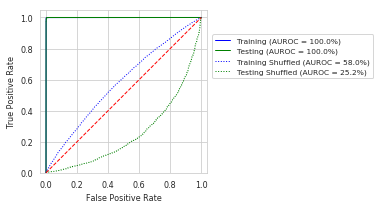

In [21]:
# Plot ROC
roc_file = pathlib.Path("figures", "metrics", "example_roc.png")

sns.set_style("whitegrid")
plt.figure(figsize=(3, 3))
total_auroc = {}
colors = ['blue', 'green', 'blue', 'green']
linestyle = ["solid", "solid", "dotted", "dotted"]
idx = 0
for label, metrics in metrics_list:
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
             label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']),
             linewidth=1, linestyle=linestyle[idx], c=colors[idx])
    total_auroc[label] = metrics['auroc']
    idx += 1

plt.axis('equal')
plt.plot([0, 1], [0, 1], color='red', linewidth=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=8)
plt.ylabel('True Positive Rate', fontsize=8)
plt.title('')
plt.tick_params(labelsize=8)
lgd = plt.legend(bbox_to_anchor=(1.03, 0.85),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=7.5)

plt.savefig(roc_file, dpi=600, bbox_extra_artists=(lgd,),
            bbox_inches='tight')

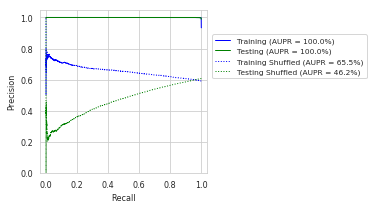

In [22]:
# Plot PR
pr_file = pathlib.Path("figures", "metrics", "example_pr.png")

sns.set_style("whitegrid")
plt.figure(figsize=(3, 3))
total_aupr = {}
idx = 0

for label, metrics in metrics_list:
    pr_df = metrics['pr_df']
    plt.plot(pr_df.recall, pr_df.precision,
             label='{} (AUPR = {:.1%})'.format(label, metrics['average_precision']),
             linewidth=1, linestyle=linestyle[idx], c=colors[idx])
    total_aupr[label] = metrics['average_precision']
    idx += 1

plt.axis('equal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=8)
plt.ylabel('Precision', fontsize=8)
plt.title('')
plt.tick_params(labelsize=8)
lgd = plt.legend(bbox_to_anchor=(1.03, 0.85),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=7.5)

plt.savefig(pr_file,
            dpi=600,
            bbox_extra_artists=(lgd,),
            bbox_inches='tight')

## Apply Models to Holdout Data

In [23]:
holdout_file = pathlib.Path("data", "example_holdout.tsv.gz")
holdout_df = pd.read_csv(holdout_file, sep="\t")

holdout_predict = cv_pipeline.decision_function(holdout_df.reindex(x_train_df.columns, axis="columns"))

In [24]:
holdout_meta_features = infer_cp_features(holdout_df, metadata=True)

holdout_pred_df = holdout_df.loc[:, holdout_meta_features]
holdout_pred_df = holdout_pred_df.assign(pred=holdout_predict)

print(holdout_pred_df.shape)
holdout_pred_df.head()

(26735, 8)


,Metadata_TableNumber,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_plate_map_name,Metadata_CellLine,Metadata_Dosage,pred
0,303468375628287550202997427545800846335,45,207106_exposure320,B10,PlateMap_207106_exposure320,CloneE,0.0,0.002268
1,267404588105155628013769033739088242832,6,207106_exposure320,B07,PlateMap_207106_exposure320,CloneA,0.0,0.264306
2,267404588105155628013769033739088242832,6,207106_exposure320,B07,PlateMap_207106_exposure320,CloneA,0.0,0.404651
3,32265043082934141884780919135581626725,217,207106_exposure320,B02,PlateMap_207106_exposure320,WT,0.0,-0.414594
4,156575971115499494274828396611545171867,73,207106_exposure320,B02,PlateMap_207106_exposure320,WT,0.0,-0.087978


In [25]:
# Apply UMAP
reducer = umap.UMAP(random_state=123)
holdout_embedding = reducer.fit_transform(holdout_df.drop(holdout_meta_features, axis="columns"))

# Setup plotting logic
holdout_embedding_df = pd.DataFrame(holdout_embedding, columns=['x', 'y'])
holdout_embedding_df = holdout_embedding_df.merge(holdout_pred_df, left_index=True, right_index=True)

/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 5 x 4 in image.
  from_inches(height, units), units))
/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/umap/example_cell_line_holdout.png
  warn('Filename: {}'.format(filename))


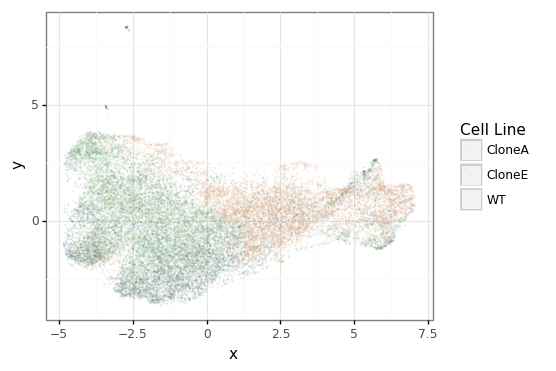

<ggplot: (8757298559180)>

In [26]:
cell_line_gg = (
    gg.ggplot(holdout_embedding_df, gg.aes(x="x", y="y")) +
    gg.geom_point(gg.aes(color="Metadata_CellLine"), size = 0.1, shape = ".", alpha = 0.1) +
    gg.theme_bw() +
    gg.scale_color_manual(name="Cell Line",
                          labels={"CloneE": "CloneE", "WT": "WT", "CloneA": "CloneA"},
                          values={"CloneE": "#3B596B", "CloneA": "#70B562", "WT": "#E49665"})
)

fig_file = pathlib.Path("figures", "umap", "example_cell_line_holdout.png")
cell_line_gg.save(filename=fig_file, height=4, width=5, dpi=500)

cell_line_gg

/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 5 x 4 in image.
  from_inches(height, units), units))
/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/umap/example_cell_line_holdout_predictions.png
  warn('Filename: {}'.format(filename))


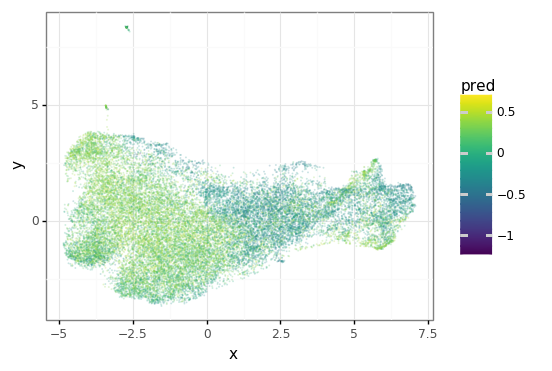

<ggplot: (8757225921323)>

In [27]:
pred_umap_gg = (
    gg.ggplot(holdout_embedding_df, gg.aes(x="x", y="y")) +
    gg.geom_point(gg.aes(color="pred"), size = 0.1, shape = ".", alpha = 0.2) +
    gg.theme_bw()
)

fig_file = pathlib.Path("figures", "umap", "example_cell_line_holdout_predictions.png")
pred_umap_gg.save(filename=fig_file, height=4, width=5, dpi=500)

pred_umap_gg

/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 5 x 4 in image.
  from_inches(height, units), units))
/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/predictions/holdout_cell_line.png
  warn('Filename: {}'.format(filename))


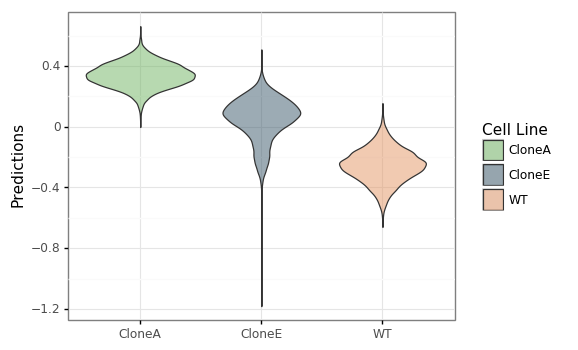

<ggplot: (-9223363279594430229)>

In [28]:
holdout_gg = (
    gg.ggplot(holdout_pred_df, gg.aes(y="pred", x="Metadata_CellLine")) +
    gg.geom_violin(gg.aes(fill="Metadata_CellLine"), alpha=0.5) +
    gg.theme_bw() +
    gg.ylab("Predictions") +
    gg.xlab("") +
    gg.scale_fill_manual(name="Cell Line",
                         values={"CloneE": "#3B596B", "CloneA": "#70B562", "WT": "#E49665"},
                         labels={"CloneE": "CloneE", "CloneA": "CloneA", "WT": "WT"})
)

fig_file = pathlib.Path("figures", "predictions", "holdout_cell_line.png")
holdout_gg.save(filename=fig_file, height=4, width=5, dpi=500)

holdout_gg